In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scorecardpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [2]:
df = pd.read_csv('Loan_Default_imputed.csv')

In [3]:
df.Status = df.Status.astype(int)

Weight of Evidence (WOE) And Information Value (IV) will be used to select features usefull for classification

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
bins = sc.woebin(df, y='Status')

[INFO] creating woe binning ...
Binning on 143942 rows and 31 columns in 00:00:25


In [6]:
df_woe = sc.woebin_ply(df, bins)

[INFO] converting into woe values ...
Woe transformating on 143942 rows and 30 columns in 00:00:15


In [7]:
iv_values = {col: bin_df['total_iv'].iloc[0] for col, bin_df in bins.items()}
iv_df = pd.DataFrame(list(iv_values.items()), columns=['Variable', 'IV'])


In [8]:
iv_df.sort_values(by='IV', ascending=False)

,Variable,IV
23,credit_type,4.657177
19,rate_of_interest,0.619766
27,Interest_rate_spread,0.231496
9,income,0.154297
13,dtir1,0.141857
25,co-applicant_credit_type,0.110648
0,submission_of_application,0.084715
18,Neg_ammortization,0.083731
10,LTV,0.062206
20,loan_amount,0.040660


In [9]:
features=iv_df[iv_df['IV']>=0.03]['Variable'].to_list()

After calculating IV, we conclude that the features 'business_or_commercial', 'rate_of_interest', 'Gender', 'loan_type', 'income', 'Neg_ammortization', 'dtir1', 'credit_type', 'property_value','Interest_rate_spread', 'LTV', 'loan_amount', 'submission_of_application', 'co-applicant_credit_type', 'Upfront_charges' have sufficient predictive power (IV>=0.03) and would be used to train models.

In [10]:
features.append('Status')

In [11]:
df_learn = df[features]
df_learn.head()

,submission_of_application,property_value,income,LTV,dtir1,Gender,Neg_ammortization,rate_of_interest,loan_amount,business_or_commercial,credit_type,loan_type,co-applicant_credit_type,Interest_rate_spread,Status
0,to_inst,118000.000000,1740.0,98.728814,45.000000,Sex Not Available,not_neg,4.199231,116500.0,nob/c,EXP,type1,CIB,0.522692,1
1,to_inst,228769.230769,4980.0,87.282005,43.615385,Male,not_neg,3.940000,206500.0,b/c,EQUI,type2,EXP,1.006962,1
2,to_inst,508000.000000,9480.0,80.019685,46.000000,Male,neg_amm,4.560000,406500.0,nob/c,EXP,type1,CIB,0.200000,0
3,not_inst,658000.000000,11880.0,69.376900,42.000000,Male,not_neg,4.250000,456500.0,nob/c,EXP,type1,CIB,0.681000,0
4,not_inst,758000.000000,10440.0,91.886544,39.000000,Joint,not_neg,4.000000,696500.0,nob/c,CRIF,type1,EXP,0.304200,0


In [12]:
numerical_columns = df_learn.select_dtypes(include=[np.number]).columns.to_list()
categorical_columns = df_learn.select_dtypes(include=['object']).columns.tolist()

oh = OneHotEncoder(sparse_output=False, handle_unknown='ignore').set_output(transform='pandas')
sc = RobustScaler()
encoded = oh.fit_transform(df_learn[categorical_columns])
scaled = pd.DataFrame(sc.fit_transform(df_learn[numerical_columns]), columns = numerical_columns)
df_enc_scal = pd.concat([encoded, scaled], axis=1)

In [13]:
df_enc_scal.head()

,submission_of_application_not_inst,submission_of_application_to_inst,Gender_Female,Gender_Joint,Gender_Male,Gender_Sex Not Available,Neg_ammortization_neg_amm,Neg_ammortization_not_neg,business_or_commercial_b/c,business_or_commercial_nob/c,...,co-applicant_credit_type_CIB,co-applicant_credit_type_EXP,property_value,income,LTV,dtir1,rate_of_interest,loan_amount,Interest_rate_spread,Status
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,-0.882353,-0.857143,0.984135,0.545455,0.318501,-0.750000,0.163920,1.0
1,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,-0.556561,-0.155844,0.506653,0.419580,-0.076112,-0.375000,0.906550,1.0
2,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.264706,0.818182,0.203719,0.636364,0.867681,0.458333,-0.330931,0.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.705882,1.337662,-0.240224,0.272727,0.395785,0.666667,0.406686,0.0
4,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,1.0,1.000000,1.025974,0.698722,0.000000,0.015222,1.666667,-0.171139,0.0


In [14]:
X, y = df_enc_scal.drop('Status', axis=1), df_enc_scal.Status
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Logistic Regression

The GridSearchCV would be used for parameter tuning and cross validation.

In the first Logistic Regression model, our focus will be on achieving the highest possible overall score.

In [15]:
logistic_model = LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=-1)
param_grid_log = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2',  None],
    'class_weight':[None, 'balanced']
}
grid_search_logistic = GridSearchCV(logistic_model, param_grid_log, cv=5, n_jobs=-1)
grid_search_logistic.fit(X_train, y_train)

print("Best Parameters:", grid_search_logistic.best_params_)
print("Best Score:", grid_search_logistic.best_score_)

Best Parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
Best Score: 0.8575026161665129


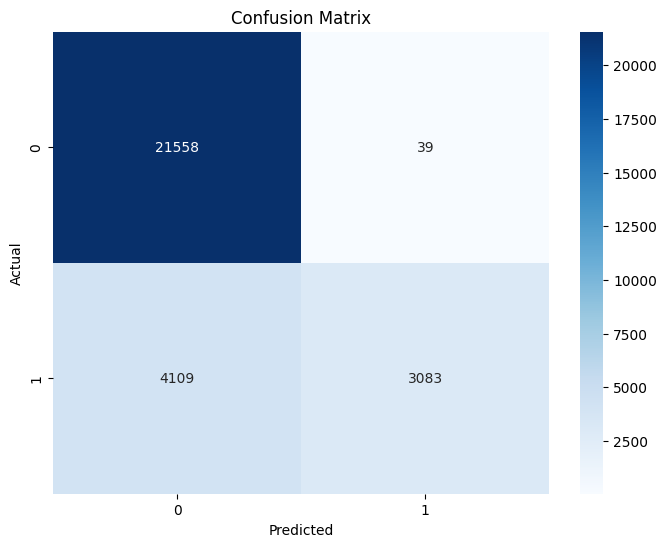

In [16]:
y_pred_log = grid_search_logistic.best_estimator_.predict(X_test)
cm_log = confusion_matrix(y_test,y_pred_log)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

In the second Logistic Regression model, our primary objective will be to reduce False Negatives, which occur when loans are approved for individuals who ultimately default on repayment. By focusing on minimizing False Negatives, we aim to enhance the model's ability to accurately identify borrowers who may pose a higher risk of default. This strategic approach helps in mitigating financial losses for lenders.

In [17]:
logistic_model_rec = LogisticRegression(max_iter=500, solver='lbfgs', n_jobs=-1)
param_grid_log_rec = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l2',  None],
    'class_weight':[None, 'balanced']
}
grid_search_logistic_rec = GridSearchCV(logistic_model_rec, param_grid_log_rec, cv=5, n_jobs=-1, scoring='recall')
grid_search_logistic_rec.fit(X_train, y_train)

print("Best Parameters:", grid_search_logistic_rec.best_params_)
print("Best Score:", grid_search_logistic_rec.best_score_)

Best Parameters: {'C': 0.0001, 'class_weight': 'balanced', 'penalty': 'l2'}
Best Score: 0.6151158806959559


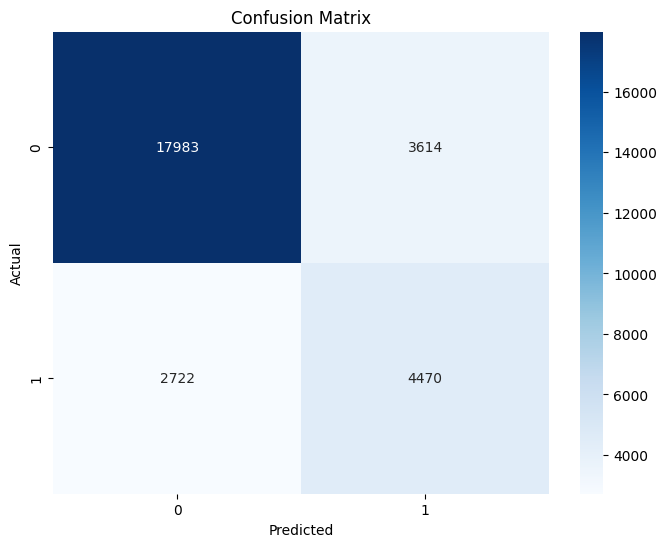

In [18]:
y_rec_pred = grid_search_logistic_rec.best_estimator_.predict(X_test)
cm_log_rec = confusion_matrix(y_test,y_rec_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_rec, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

The overall accuracy of the second model is lower compared to the first model. However, we achieved a significant reduction in False Negatives and an increase in True Positives.

# SVM

In [21]:
pip install scikit-learn-intelex

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.1
[notice] To update, run: C:\Users\Bartek\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import sklearnex
from sklearnex import patch_sklearn
patch_sklearn()
from sklearn.svm import SVC

svm_model = SVC()

param_grid_svm = {
    'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['rbf'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 'scale', 'auto'],
    'class_weight': [None, 'balanced']
}

grid_search_svm = GridSearchCV(svm_model, param_grid_svm, cv=5, n_jobs=-1)
grid_search_svm.fit(X, y)

print("Best Parameters:", grid_search_svm.best_params_)
print("Best Score:", grid_search_svm.best_score_)

ModuleNotFoundError: No module named 'sklearnex'

In [ ]:
y_svm_pred = grid_search_svm.best_estimator_.predict(X)
cm_log_rec = confusion_matrix(y,y_svm_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_log_rec, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()